In [24]:
################ Library imports ################
import numpy as np
import math as math
import matplotlib.pyplot as plt
import pandas as pd
import glob
import seaborn as sns
import itertools

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy.optimize import curve_fit

In [25]:
"""
Plot styling
"""
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)

sns.set_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [26]:
"""
File reading
"""
path = '../data/Google - Orientacion vertical' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col = None, sep = ",", header = None)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

In [27]:
"""
Two states model: Least Squares
m1 --> first slope
n1 --> first ordinate
m2 --> second slope
n2 --> second ordinate
x --> data
"""
def two_lin(x, m1, n1, m2, n2):
    return np.min([m1 * x + n1, m2 * x + n2], axis = 0)

In [28]:
"""
Array definition and curve fitting
"""
real_distance = np.array(frame.loc[:, 1])
estimated_distance = np.array(frame.loc[:, 2])
#x = np.array([0, 1, 2,  3,  4,  5,  6,  7,  8,  9,  10])
#y = np.array([2, 4, 8, 12, 14, 18, 20, 21, 22, 23,  24])

"""
Initial values
"""
start_values = [3, 0, 0, 10]
fit_param, pcov = curve_fit(two_lin, real_distance, estimated_distance, p0 = start_values)

In [29]:
"""
Output values for slopes/ordinates
"""
m1, n1, m2, n2 = fit_param
print("Values: ", m1, n1, m2, n2)

Values:  1.6260619505325347 -3.0670180013313364 0.9789604129755792 -0.33674919534231956


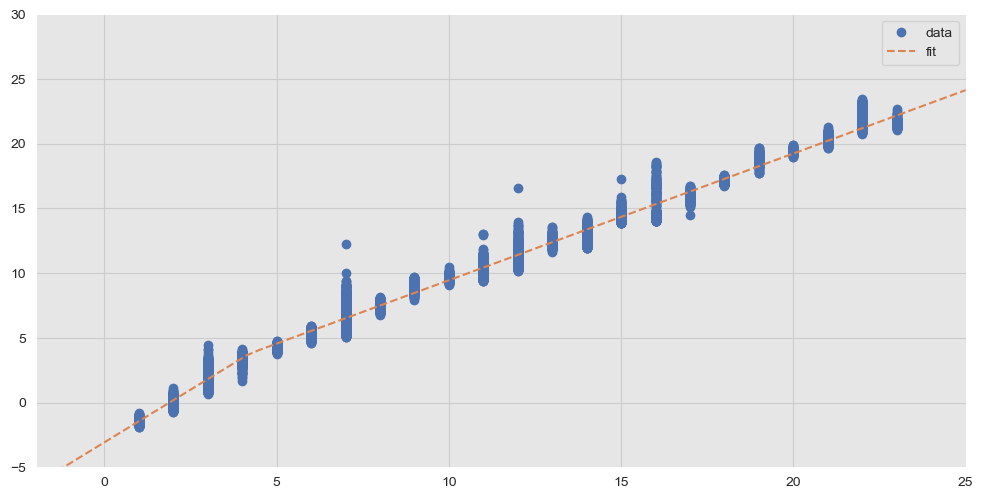

In [30]:
"""
Two-Line model plot
"""
x_fit = np.linspace(-10, 25, 100)  
plt.plot(real_distance, estimated_distance, 'o', label='data')
plt.plot(x_fit, two_lin(x_fit, *fit_param), '--', label='fit')

plt.axis([-2, 25, -5, 30])
plt.legend()
plt.show()

In [31]:
# ----------------------------------------------------------------------
#  AP locations
L_ap = np.array([[0, 0], [0, 2], [2, 0], [2, 2]])

# ----------------------------------------------------------------------
#  VRP locations
L_vrp = np.array([[1, 0], [0, 1], [1, 1], [1, 2], [2, 1]])

# ----------------------------------------------------------------------
#  RTT distance observations
d_RTT = np.array([-3, 0.2, 0.17, 1.5])

In [32]:
"""
Compute Euclidean distance vector
    
    target --> Reference AP location to calculate distance
    array --> Array of AP/VRP locations
"""
def compute_euclidean_distance_vector(target, array):
    d_vec = np.array([np.linalg.norm(target - i) for (i) in array])
    return d_vec

In [33]:
"""
RTT observations and mean values

    d_RTT --> RTT observations between APs
    ap_loc --> Target AP location
    m_ap --> Mean RTT model value at target AP
    m_vrp --> Mean RTT model value between target AP and each VRP 
"""
ap_loc = L_ap[0]

m_ap = two_lin(compute_euclidean_distance_vector(ap_loc, [L_ap[0]]), *fit_param)[0]
m_vrp = two_lin(compute_euclidean_distance_vector(ap_loc, L_vrp), *fit_param)
print(m_ap)
print(m_vrp)

-3.0670180013313364
[-1.44095605 -1.44095605 -0.76741914  0.56896706  0.56896706]


In [34]:
"""
Gaussian Process Kernel definition

Kernel parameters:
    - L --> Length Scale
    - sigma_f --> Constant Kernel Amplitude
"""

def kernel_function(x, y, sigma_f=1, l=1):

    """ Squared Exponential kernel function """
    kernel = sigma_f * np.exp(- (np.linalg.norm(x - y)**2) / (2 * l**2))
    return kernel

In [35]:
def compute_cov_matrices(L_ap, L_vrp, sigma_f=1, l=1):
    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
    
        - K = K(L, L) 
        - K_star = K(L^*, L)
        - K_star2 = K(L^*, L^*)
    """
    n = L_ap.shape[0]
    n_star = L_vrp.shape[0]

    K = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(L_ap, L_ap)]

    K = np.array(K).reshape(n, n)
    
    K_star2 = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(L_vrp, L_vrp)]

    K_star2 = np.array(K_star2).reshape(n_star, n_star)
    
    K_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(L_vrp, L_ap)]

    K_star = np.array(K_star).reshape(n_star, n)
    
    return (K, K_star2, K_star)

In [36]:
"""
Computing covariance matrices
"""
l = 1
sigma_f = 4

K, K_star2, K_star = compute_cov_matrices(L_ap, L_vrp, sigma_f=sigma_f, l=l)

In [37]:
"""
Gaussian Process Regressor definition

- sigma_n --> Training Noise Variance

Multivariate Joint Distribution: G matrix
"""

n = L_ap.shape[0]
n_star = L_vrp.shape[0]

sigma_n = 0.2

a = np.concatenate((K + (sigma_n**2)*np.eye(n), K_star), axis=0)
print(a.shape)
b = np.concatenate((K_star.T, K_star2), axis=0)
print(b.shape)
G = np.concatenate((a, b), axis=1)
print(G.shape)
G.shape == (n + n_star, n + n_star)

(9, 4)
(9, 5)
(9, 9)


True

In [38]:
def compute_gpr_parameters(K, K_star2, K_star, sigma_n):
    
    """Compute gaussian regression parameters."""

    n = K.shape[0]
    n_star = K_star.shape[0]

    # Mean.
    s_bar_star = (m_vrp.reshape([n_star, 1]) 
        + np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), d_RTT.reshape([n, 1]) - m_ap)))
    # Covariance.
    cov_s_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), K_star.T))
    
    return (s_bar_star.reshape(n_star), cov_s_star)

In [39]:
"""
Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

s_bar_star, cov_s_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)
var_s_star = np.diag(cov_s_star)
print("Mean estimated values: ", s_bar_star)
print("Covariance matrix values: \n", cov_s_star)
print("Variance of estimations at VRPs: \n", var_s_star)

Mean estimated values:  [0.3134587 0.329324  2.386939  4.7190421 4.7031768]
Covariance matrix values: 
 [[1.43041208 0.0113282  0.86596723 0.19054993 0.0113282 ]
 [0.0113282  1.43041208 0.86596723 0.0113282  0.19054993]
 [0.86596723 0.86596723 2.33303501 0.86596723 0.86596723]
 [0.19054993 0.0113282  0.86596723 1.43041208 0.0113282 ]
 [0.0113282  0.19054993 0.86596723 0.0113282  1.43041208]]
Variance of estimations at VRPs: 
 [1.43041208 1.43041208 2.33303501 1.43041208 1.43041208]
